## **Import Libraries**

In [45]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import graphviz
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## **Load dataset**

In [34]:
data = load_breast_cancer()
features = pd.DataFrame(data.data, columns=data.feature_names)
labels = pd.Series(data.target, name="target")
classes_name = {
    0: "Malignant",
    1: "Benign"
}

## **Split dataset into training and testing set**

### **Save data**

In [ ]:
def split_and_save_data(features, labels, ratio_test=0.4, root_folder='data'):
    """
    Splits the dataset into training and testing sets based on the specified ratio, 
    then saves the split data into CSV files within a structured folder hierarchy.

    Args:
        features (pd.DataFrame): Input dataset containing the features to be split.
        labels (pd.Series): Corresponding labels for the input dataset.
        ratio_test (float, optional): Proportion of the data to be used for testing. 
            Defaults to 0.4 (60% train, 40% test).
        root_folder (str, optional): Root directory where the split data will be saved. 
            Defaults to 'data.
    """
    
    train_percent = int((1 - ratio_test) * 100)
    test_percent = int(ratio_test * 100)
    
    os.makedirs(root_folder, exist_ok=True)
    
    base_folder_name = f"train_{train_percent}_test_{test_percent}"
    base_folder = os.path.join(root_folder, base_folder_name)
    os.makedirs(base_folder, exist_ok=True)
    
    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=ratio_test, random_state=42)
    for train_index, test_index in sss.split(features, labels):
        train_features, test_features = features.iloc[train_index], features.iloc[test_index]
        train_labels, test_labels = labels.iloc[train_index], labels.iloc[test_index]
        
        train_features.to_csv(os.path.join(train_folder, "feature_train.csv"), index=False)
        train_labels.to_csv(os.path.join(train_folder, "label_train.csv"), index=False, header=False)
        
        test_features.to_csv(os.path.join(test_folder, "feature_test.csv"), index=False)
        test_labels.to_csv(os.path.join(test_folder, "label_test.csv"), index=False, header=False)
    
    

In [38]:
split_and_save_data(features, labels, ratio_test=0.6)
split_and_save_data(features, labels, ratio_test=0.4)
split_and_save_data(features, labels, ratio_test=0.2)
split_and_save_data(features, labels, ratio_test=0.1)

### **Training and testing data**

In [37]:
def load_split_data(data_split_folder='train_40_test_60'):
    """
    Loads the train and test datasets from CSV files saved previously, 
    based on the specified ratio for the test dataset.

    Args:
        ratio_test (float, optional): Proportion of the data to be used for testing. 
            Defaults to 0.4 (40% test, 60% train).
        root_folder (str, optional): Root directory where the split data is saved. 
            Defaults to "data".

    Returns:
        X_train (pd.DataFrame): The features of the training set.
        y_train (pd.Series): The labels of the training set.
        X_test (pd.DataFrame): The features of the testing set.
        y_test (pd.Series): The labels of the testing set.
    """
    
    train_folder = os.path.join(data_split_folder, "train")
    test_folder = os.path.join(data_split_folder, "test")
    
    X_train = pd.read_csv(os.path.join(train_folder, "feature_train.csv"))
    y_train = pd.read_csv(os.path.join(train_folder, "label_train.csv"), header=None).squeeze()
    
    X_test = pd.read_csv(os.path.join(test_folder, "feature_test.csv"))
    y_test = pd.read_csv(os.path.join(test_folder, "label_test.csv"), header=None).squeeze()
    
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_split_data(data_split_folder='train_40_test_60')

### **Visualize the data**

In [ ]:
def visualize_class_distribution(original_labels, train_labels, test_labels):
    """
    Visualizes the distribution of class labels in the original, training, and testing datasets 
    using bar plots for easy comparison.

    Args:
        original_labels (pd.Series): The class labels from the original dataset.
        train_labels (pd.Series): The class labels from the training dataset.
        test_labels (pd.Series): The class labels from the testing dataset.
    """
    
    original_counts = original_labels.value_counts()
    train_counts = train_labels.value_counts()
    test_counts = test_labels.value_counts()
    
    classes = sorted(original_counts.index)
    original_counts = original_counts.reindex(classes)
    train_counts = train_counts.reindex(classes)
    test_counts = test_counts.reindex(classes)
    
    plt.figure(figsize=(12, 6))
    
    x = range(len(classes))
    width = 0.2
    
    plt.bar([i - width for i in x], original_counts, width=width, label='Original', color='blue')
    plt.bar(x, train_counts, width=width, label='Train', color='green')
    plt.bar([i + width for i in x], test_counts, width=width, label='Test', color='red')
    
    plt.xticks(x, [f'Class {cls}' for cls in classes])
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Class Distribution in the Original, Train, and Test Datasets')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

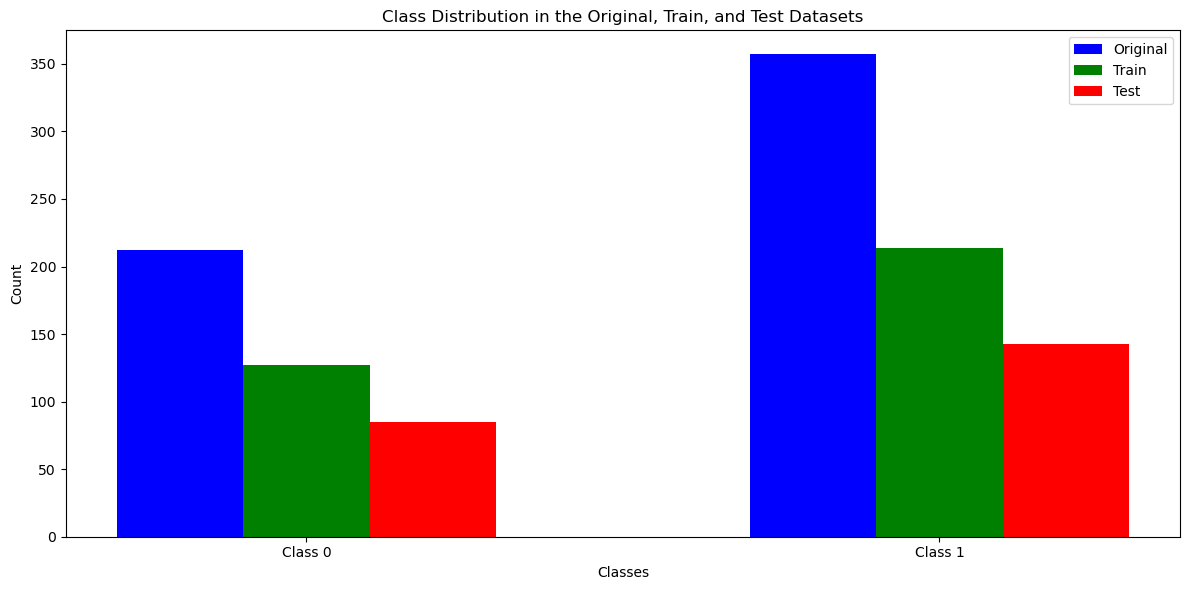

In [9]:
visualize_class_distribution(
    original_labels=labels,
    train_labels=y_train,
    test_labels=y_test
)

## **Training**

In [39]:
def train_decision_tree(X_train, y_train, criterion='entropy', max_depth=None, feature_names=None, graphviz_path=None):
    """
    Trains a decision tree classifier on the input features and labels, and optionally visualizes the tree.
    
    Args:
        X_train (pd.DataFrame): The input features of the training set.
        y_train (pd.Series): The labels of the training set.
        criterion (str, optional): The function to measure the quality of a split. 
            Defaults to 'entropy'. Can be 'gini' for the Gini impurity.
        max_depth (int, optional): The maximum depth of the decision tree. 
            Defaults to None, meaning the tree is expanded until all leaves are pure.
        feature_names (list of str, optional): A list of feature names. If provided, 
            the tree will be visualized with these feature names.
        graphviz_path (str, optional): Path where the decision tree visualization should be saved as a PNG image. 
            If None, the tree won't be saved.

    Returns:
        model (DecisionTreeClassifier): The trained decision tree classifier.
    """
    
    # Train decision tree classifier
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Visualize the decision tree  
    if feature_names is not None:
        dot_data = export_graphviz(
            model, out_file=None,
            feature_names=feature_names,
            class_names=[classes_name[label] for label in np.unique(y_train)],
            filled=True, rounded=True,
            special_characters=True
        )
        
        graph = graphviz.Source(dot_data)
        
        if graphviz_path is not None:
            graph.render(graphviz_path, format='png', cleanup=True)
    
    return model

In [ ]:
model = train_decision_tree(X_train, y_train, max_depth=2, feature_names=X_train.columns)

## **Evaluation**

In [64]:
def evaluate_decision_tree(model, X_test, y_test, report_path=None, heatmap_path=None):
    """
    Evaluates the performance of a trained decision tree model on the test dataset.
    It prints the classification report, saves it to an Excel file, and visualizes 
    the confusion matrix as a heatmap.

    Args:
        model (DecisionTreeClassifier): The trained decision tree model to evaluate.
        X_test (pd.DataFrame): The input features of the test dataset.
        y_test (pd.Series): The true labels of the test dataset.
        report_path (str, optional): The path where the classification report should be saved as an Excel file.
            If None, the report will not be saved.
        heatmap_path (str, optional): The path where the confusion matrix heatmap should be saved as an image file.
            If None, the heatmap will not be saved.
            
    Returns:
        accuracy (float): The accuracy of the model on the test dataset.
    """
    
    labels_name = [classes_name[i] for i in np.unique(y_test)]
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=[label_name[0] for label_name in labels_name], output_dict=True) 
    # print(pd.DataFrame(report))
    
    report_df = pd.DataFrame(report).transpose()
    
    if report_path is not None:
        report_df.to_excel(report_path)
    
    
    # print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name, annot_kws={'size': 16})
    plt.title('Decision Tree Classifier confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True')
    plt.tight_layout()
    
    if heatmap_path is not None:
        plt.savefig(heatmap_path)
    
    # plt.show()
    
    return accuracy

Classification Report:
                   M           B  accuracy   macro avg  weighted avg
precision   0.843750    0.969697  0.916667    0.906723      0.922743
recall      0.952941    0.895105  0.916667    0.924023      0.916667
f1-score    0.895028    0.930909  0.916667    0.912968      0.917532
support    85.000000  143.000000  0.916667  228.000000    228.000000
Confusion Matrix:
[[ 81   4]
 [ 15 128]]


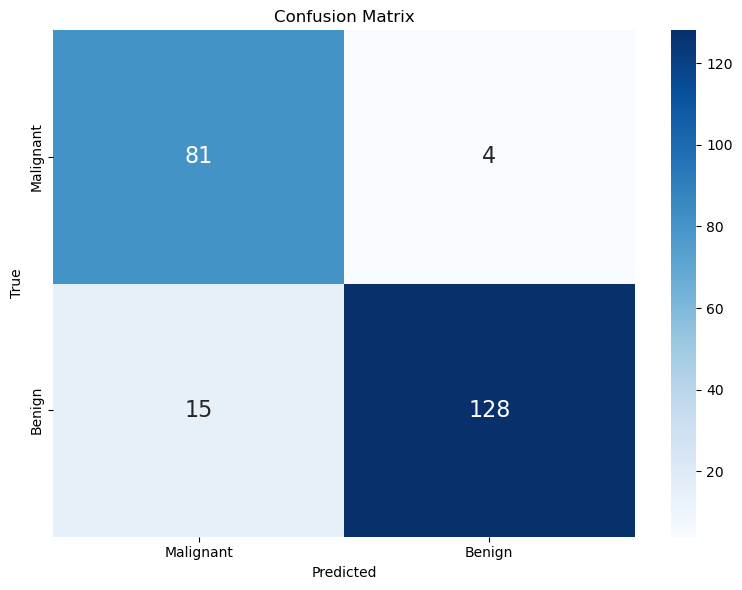

In [36]:
evaluate_decision_tree(model, X_test, y_test, max_depth=2)

## **Save outputs**

In [90]:
def process_data_with_max_depth(data_root='data', output_root='outputs', depths=[None, 2, 3, 4, 5, 6, 7]):
    
    os.makedirs(output_root, exist_ok=True)
    
    for data_split in os.listdir(data_root):
        data_split_path = os.path.join(data_root, data_split)
        depth_accuracy = []
        
        if os.path.isdir(data_split_path):
            X_train, y_train, X_test, y_test = load_split_data(data_split_folder=data_split_path)
            
            output_split_path = os.path.join(output_root, data_split)
            os.makedirs(output_split_path, exist_ok=True)
            
            for max_depth in depths:
                output_depth_path = os.path.join(output_split_path, f"depth_{max_depth}")
                os.makedirs(output_depth_path, exist_ok=True)
                
                graphviz_path = os.path.join(output_depth_path, f'bcw_{data_split}_depth_{max_depth}_graphviz')
                report_path = os.path.join(output_depth_path, f'bcw_{data_split}_depth_{max_depth}_report.xlsx')
                heatmap_path = os.path.join(output_depth_path, f'bcw_{data_split}_depth_{max_depth}_heatmap.png')
                
                model = train_decision_tree(X_train, y_train, max_depth=max_depth, feature_names=X_train.columns, graphviz_path=graphviz_path)
                accuracy = evaluate_decision_tree(model, X_test, y_test, report_path=report_path, heatmap_path=heatmap_path)
                depth_accuracy.append((max_depth if max_depth is not None else 'None', accuracy))
                
            depth_accuracy_data = {
                'max_depth': ['max_depth'] + [depth if depth is not None else 'None' for depth, _ in depth_accuracy],
                'accuracy': ['Accuracy'] + [accuracy for _, accuracy in depth_accuracy]
            }
            
            depth_accuracy_df = pd.DataFrame(depth_accuracy_data).T
                        
            excel_path = os.path.join(output_split_path, f'bcw_{data_split}_depth_accuracy.xlsx')
            depth_accuracy_df.to_excel(excel_path, index=False, header=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1932\3279393223.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


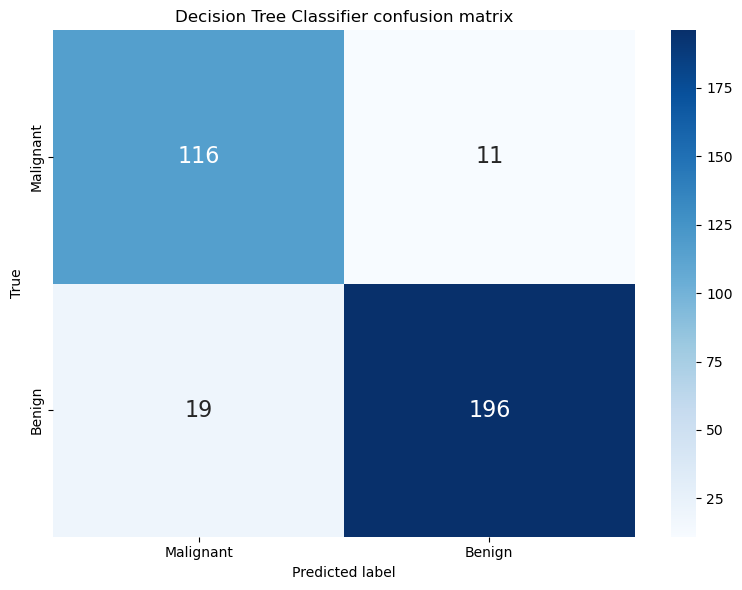

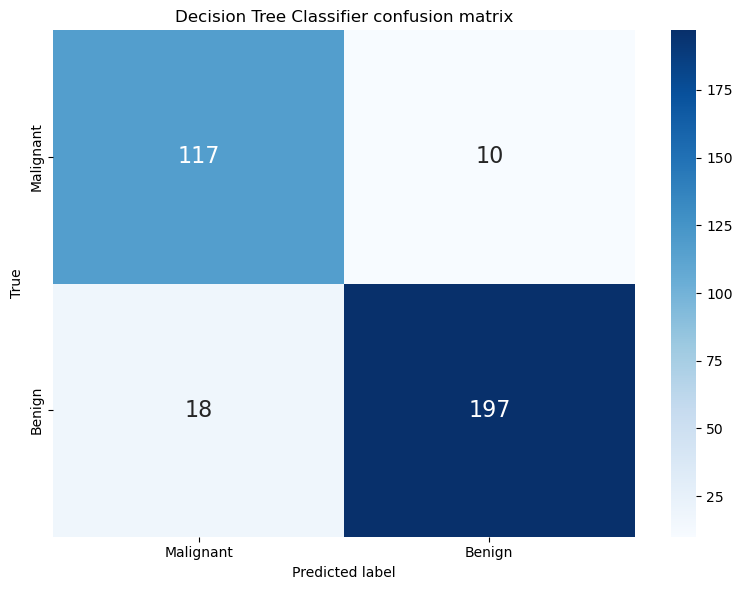

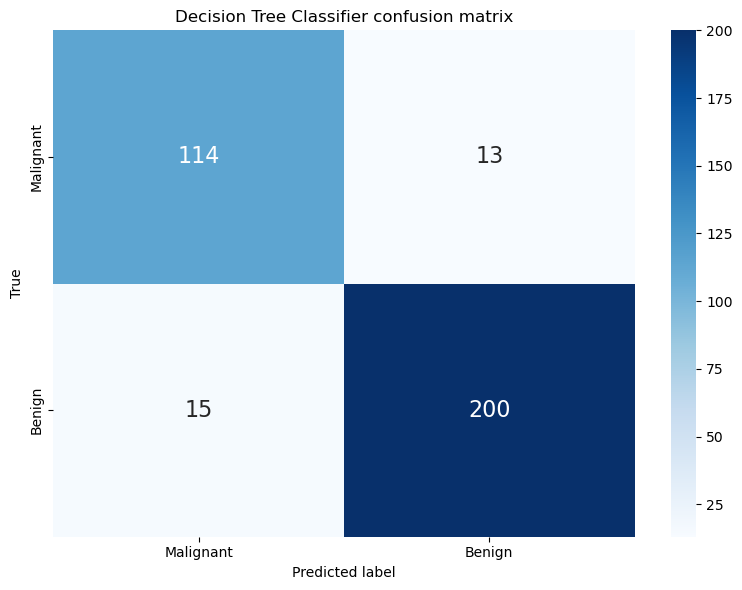

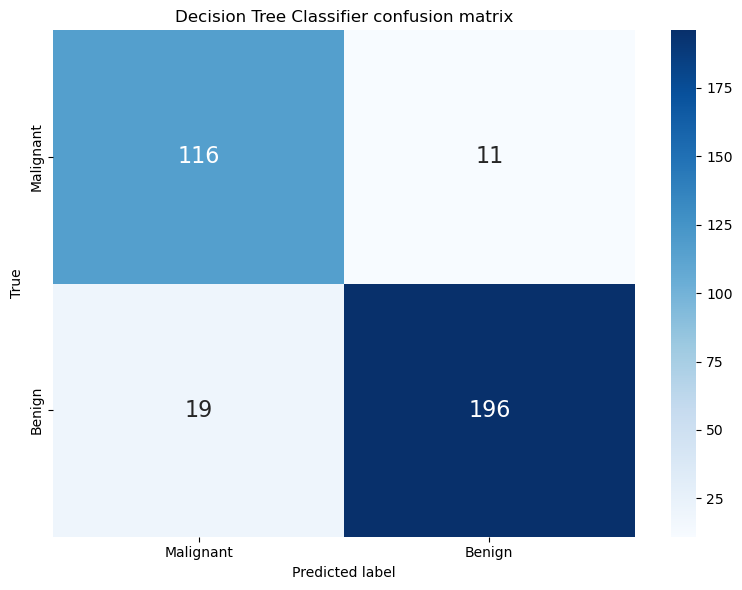

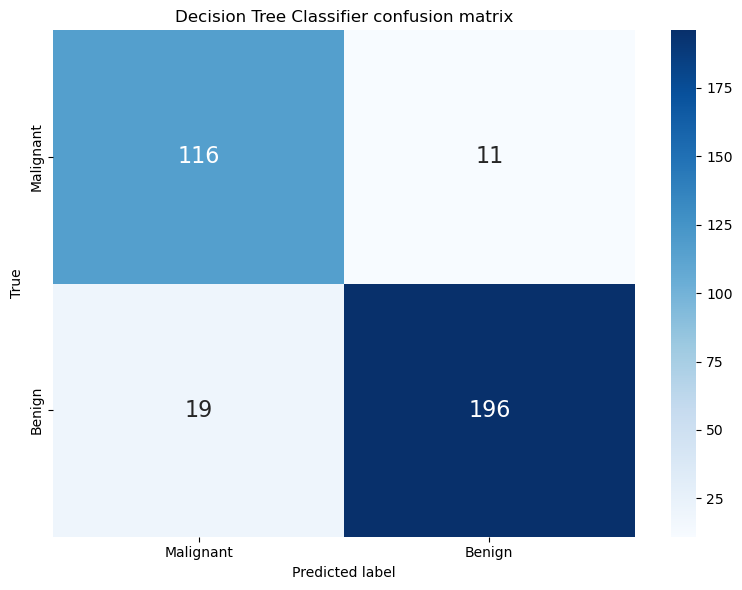

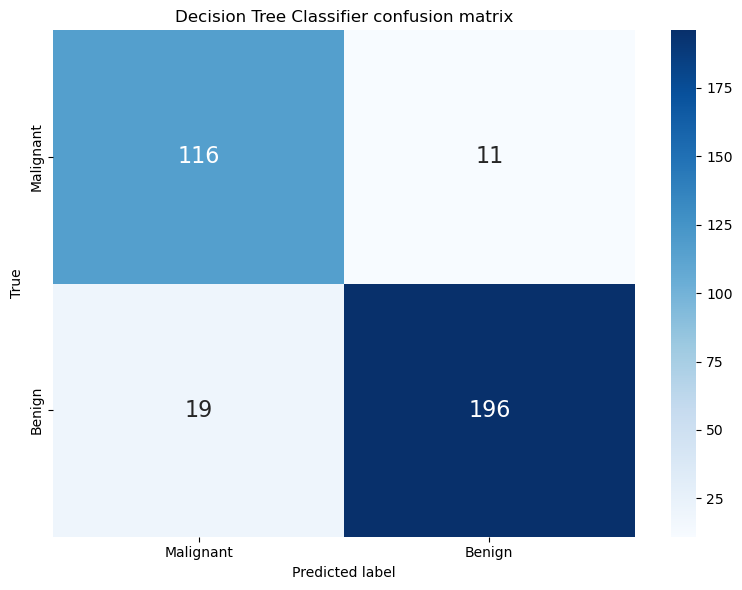

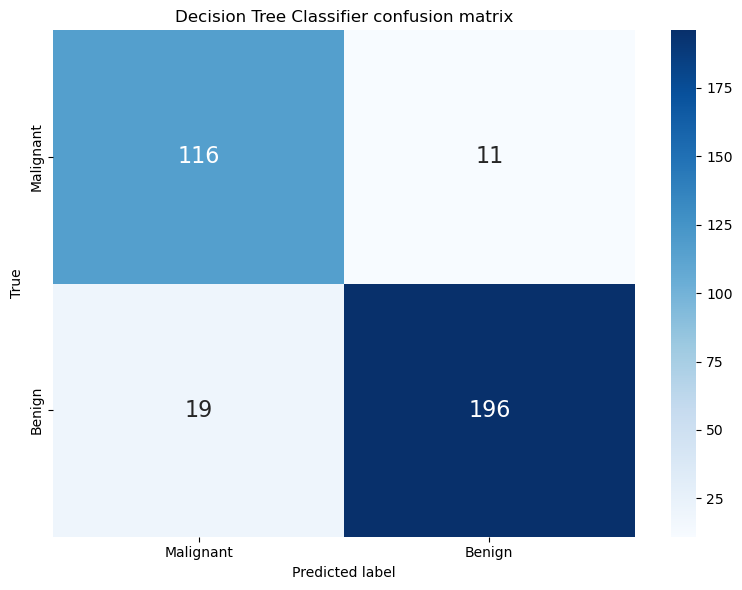

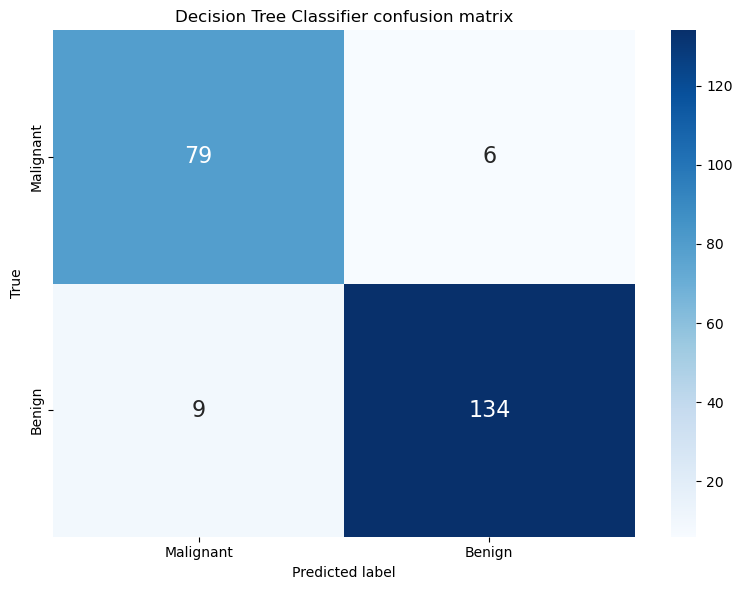

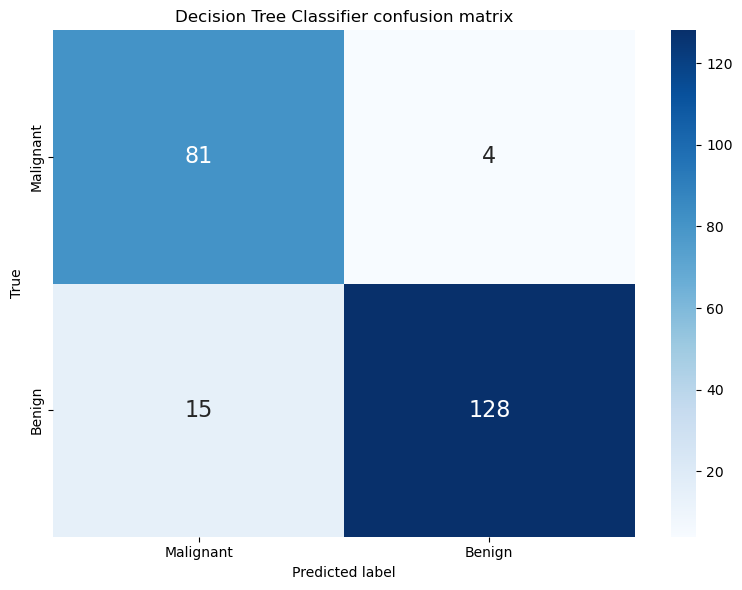

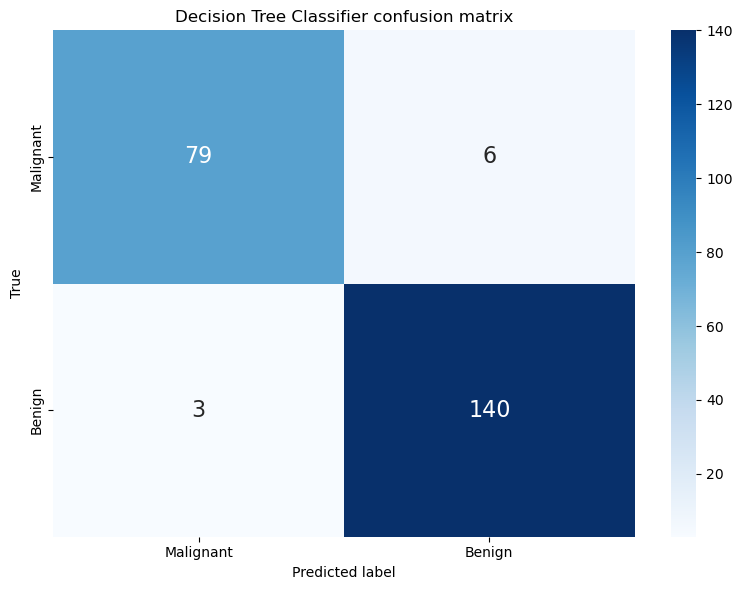

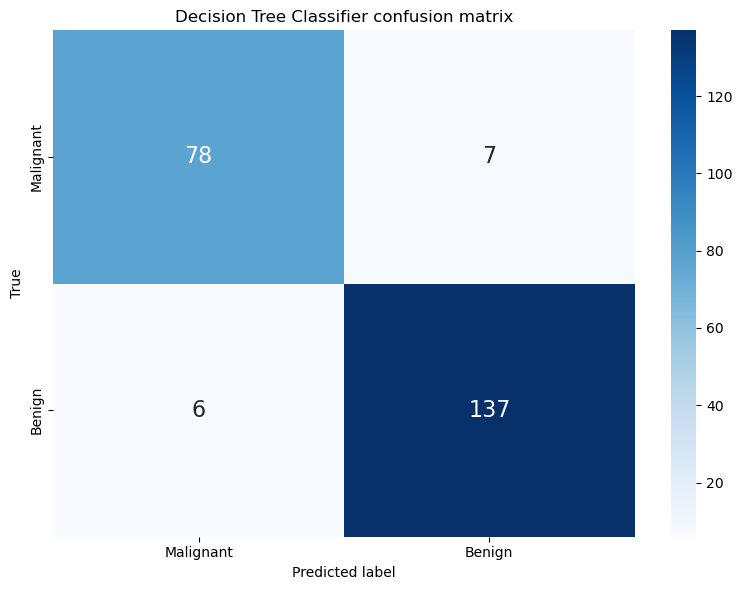

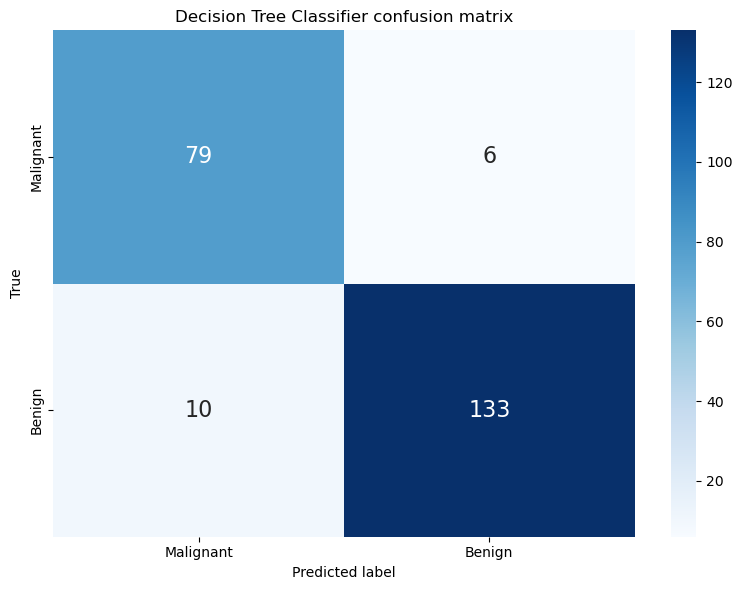

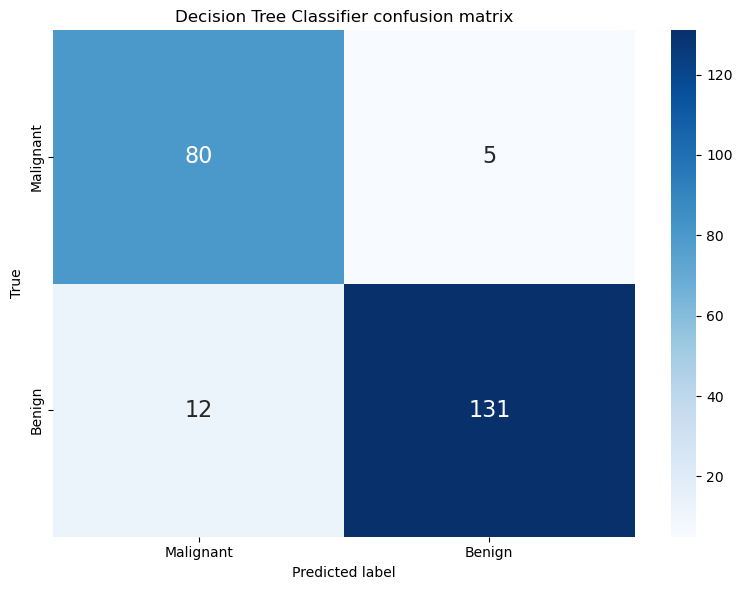

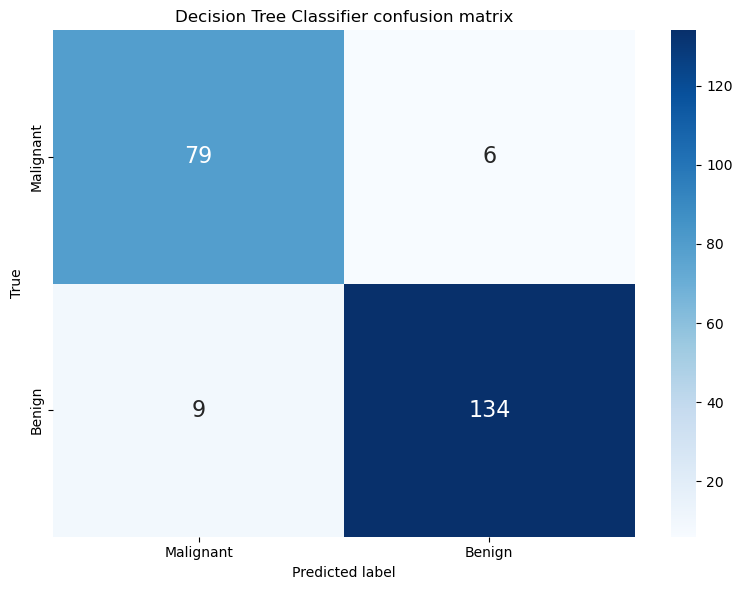

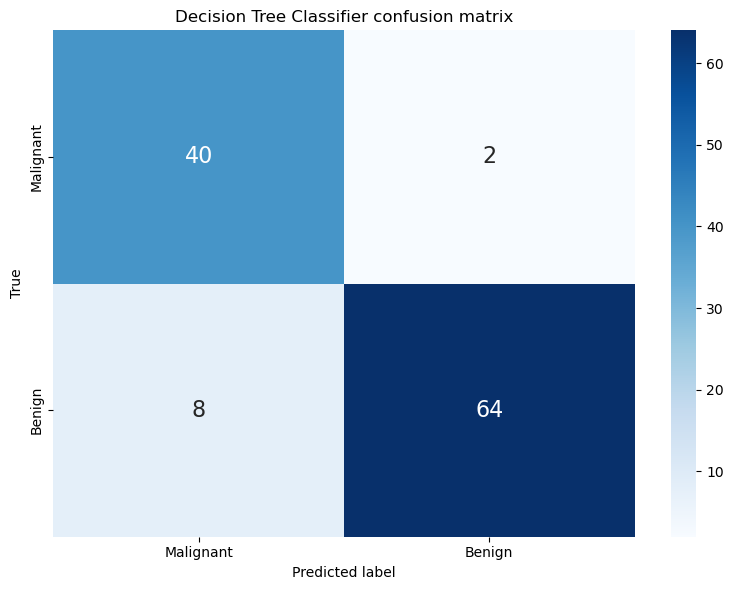

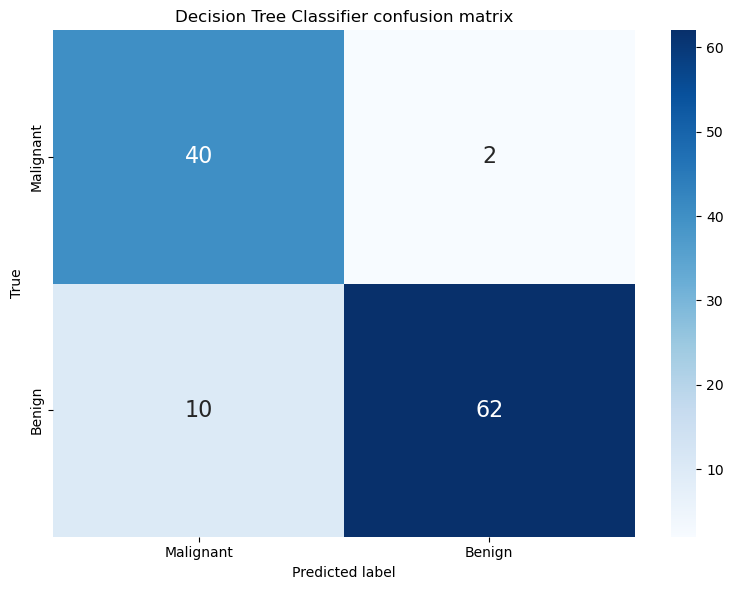

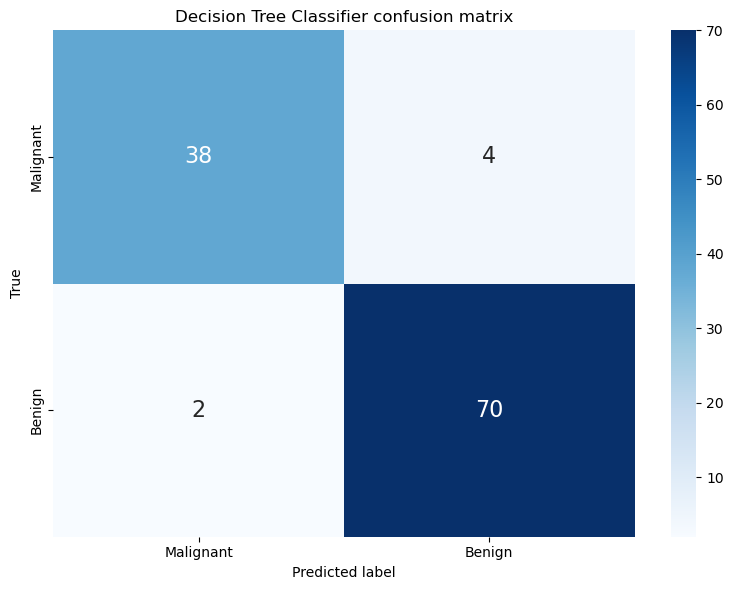

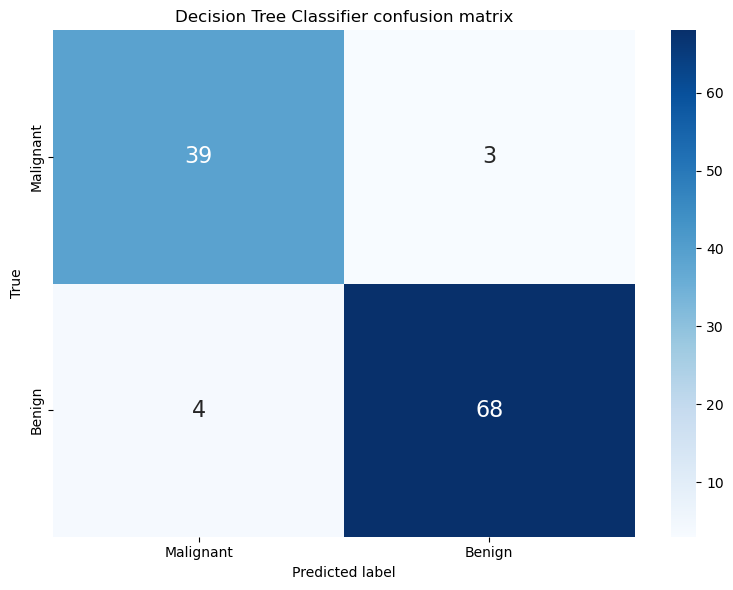

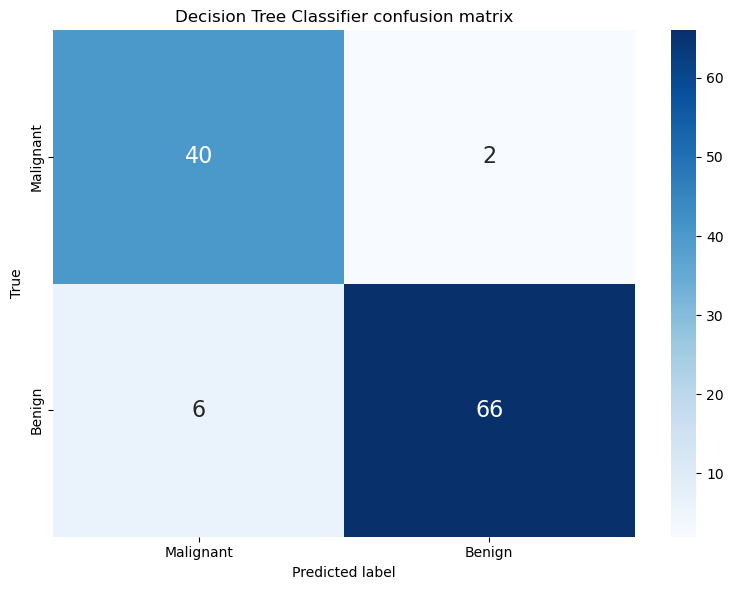

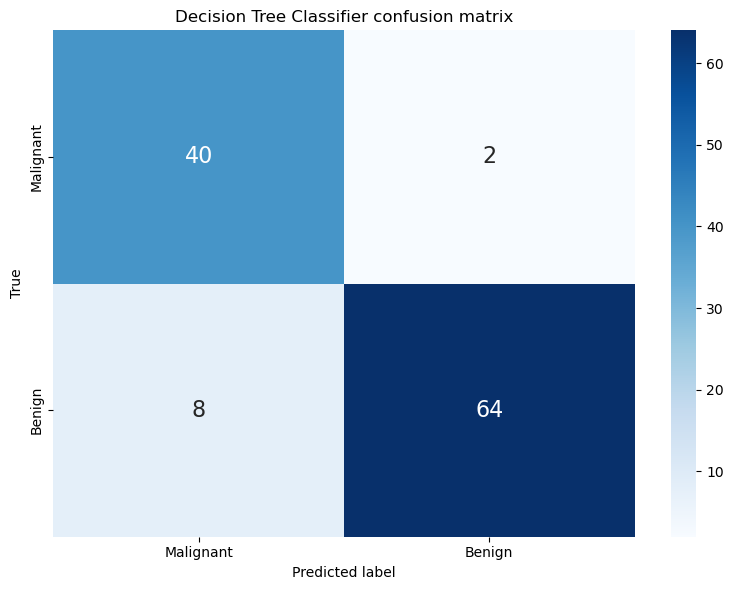

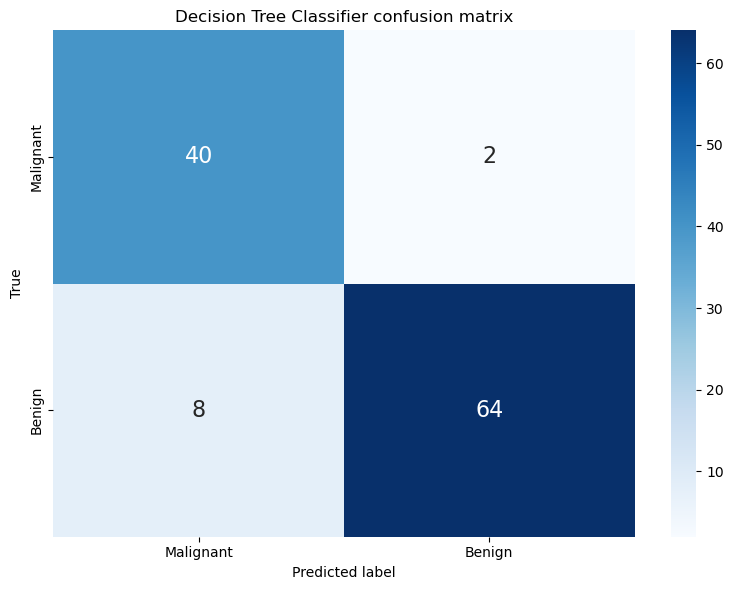

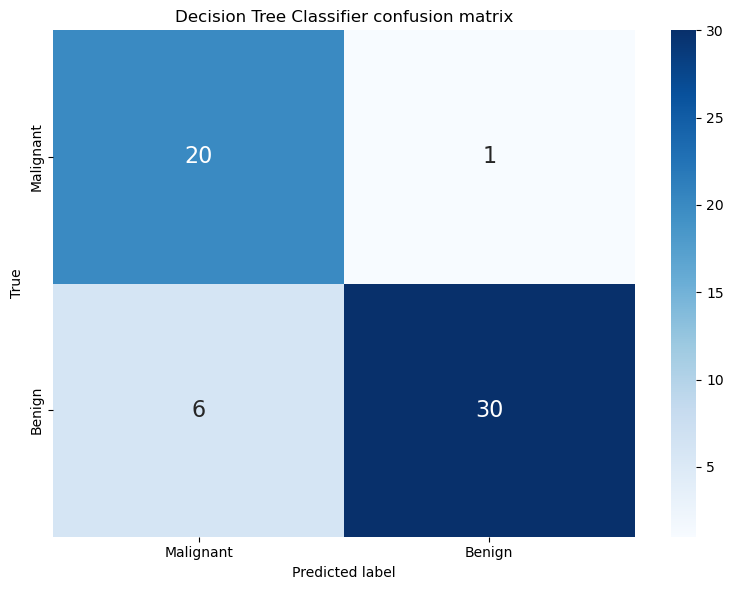

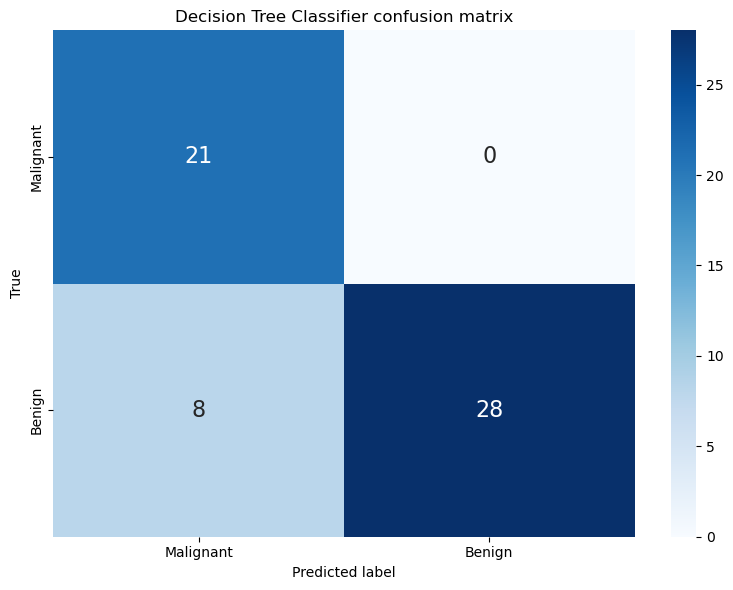

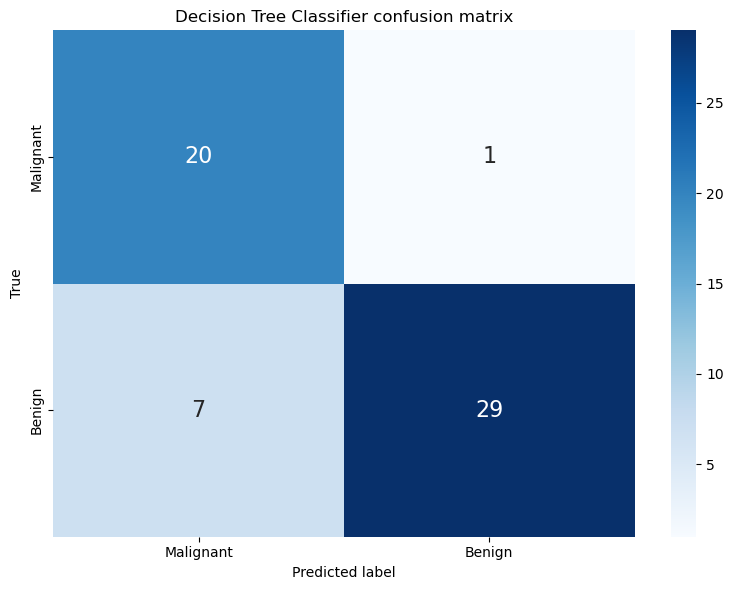

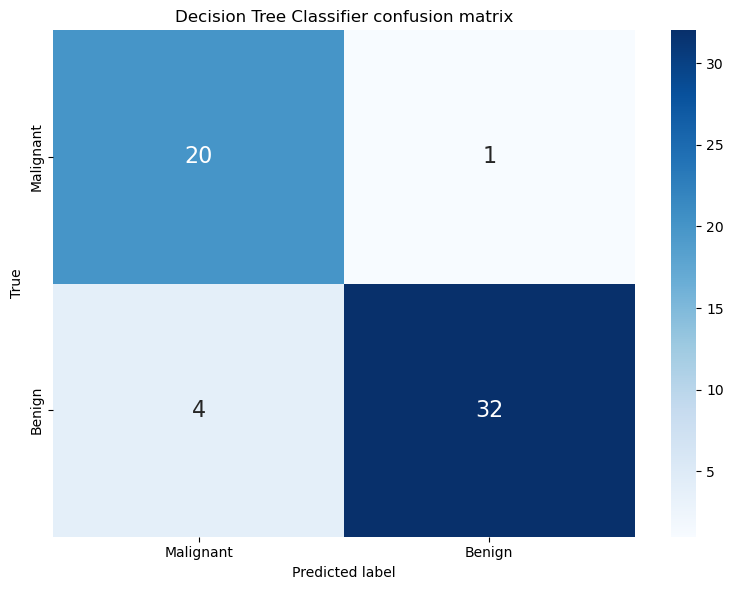

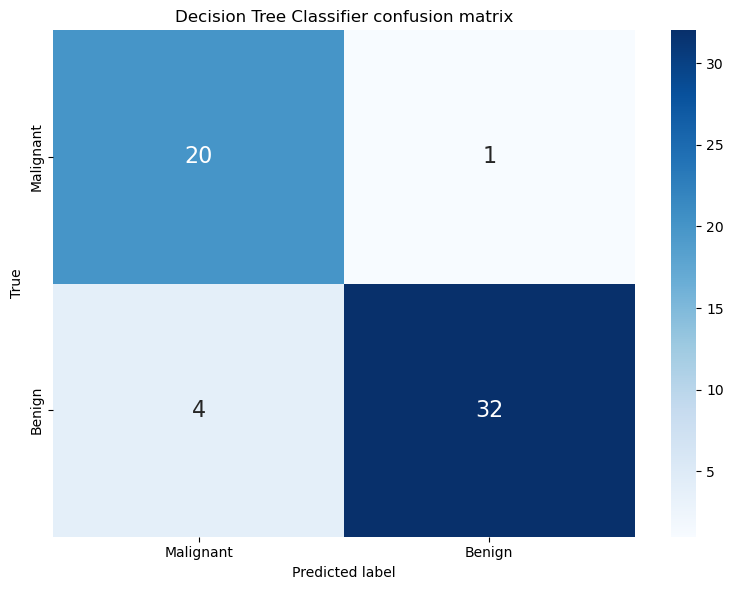

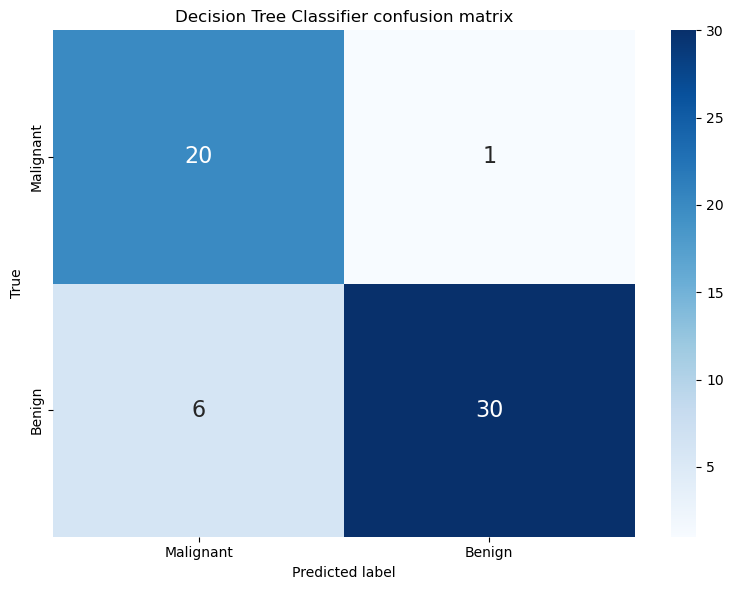

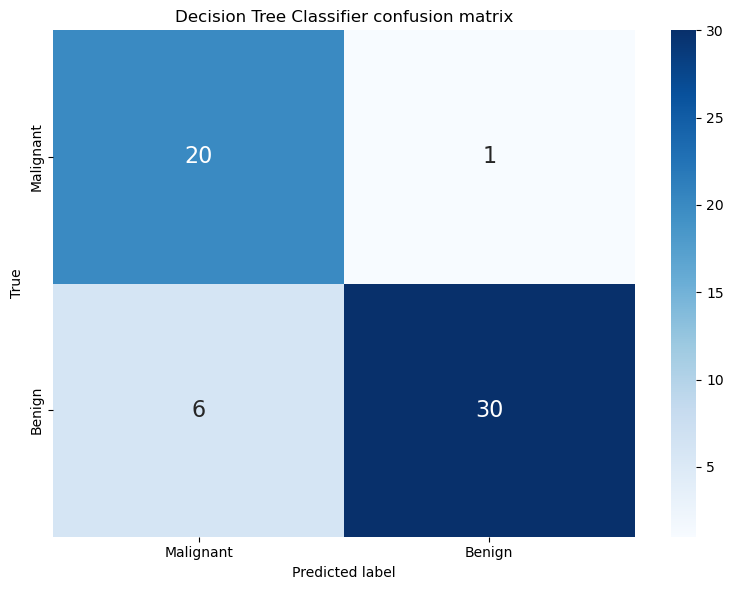

In [91]:
process_data_with_max_depth()